# Notebook to test the Cormack algorithm for the inverse problem

## Problem statement:
$f(p, \phi) = \int_{L(\mathbf{p})} \,g(r, \theta)$, find $g(r, \theta)$ from $f(p, \phi)$.

In [1]:
from utils import *
from math import factorial as fact
from scipy.special import jn, jn_zeros, jv, jvp # jvp is the derivative of jn
from scipy.integrate import quad
from numpy.linalg import lstsq

DEV: cpu


cp: train.py: No such file or directory


In [2]:
IDX = np.random.randint(0, 69352)
M = 2
L = 7
FINESSE = 110
RFX_I = 0 # index of the rfx fan [0:vdi, 1:vdc, 2:vde, 3:hor]
SVD_TRSH = 0.06

## Data

In [3]:
#load data_clean.npy
d = np.load('data/data_clean.npy')
print(f'Keys in data: {d.dtype.names}')
SXR = d['data'][IDX][RFX_COMBINED_INTERVALS]
EMISS = d['emiss'][IDX]
BESSEL_COEFSS = d['target'][IDX]
# XX_GT, YY_GT = np.meshgrid(d['x_emiss'][IDX], d['y_emiss'][IDX][::-1]) # # NOTE: it's flipped up/down bc it's saved as an image with (0,0) at top left)
XX_GT, YY_GT = np.meshgrid(d['x_emiss'][IDX], d['y_emiss'][IDX]) # # NOTE: NOT FLIPPED
XY_GT = np.stack([XX_GT, YY_GT], axis=-1)
MAJR, MINR = d['majr'][IDX], d['minr'][IDX]
print(f'SXR: {SXR.shape}, emiss: {EMISS.shape}, BESSEL_COEFSS: {BESSEL_COEFSS.shape}, XY_GT: {XY_GT.shape}')

# recalculate SXR
to_conc = [eval_rfx_sxr(create_default_rfx_fan(n), resize2d(EMISS, (GSIZE,GSIZE))) for n in RFX_SXR_NAMES]
SXR2 = np.concatenate(to_conc, axis=-1)

Keys in data: ('label', 'shot', 'time', 'prel', 'data', 'data_err', 'target', 'emiss', 'x_emiss', 'y_emiss', 'majr', 'minr', 'b_tor', 'b_rad', 'phi_tor')
SXR: (68,), emiss: (110, 110), BESSEL_COEFSS: (21,), XY_GT: (110, 110, 2)


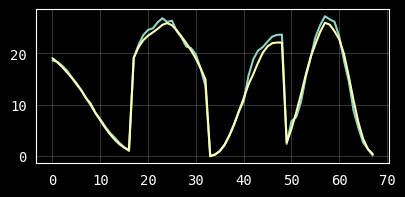

In [4]:
# plot SXR and SXR2
plt.figure(figsize=(10,2))
plt.subplot(121)
plt.plot(SXR)
plt.plot(SXR2)
plt.show()
SXR = SXR2

Bessel coeffs are 21, 3x7, because there are 2 coefss for cosine (0 and 1), both non-zero, and 1 for sine (1), bc the sine(0) is zero.

In [5]:
# a0cl, a1cl, a1sl = BESSEL_COEFSS[0:L], BESSEL_COEFSS[L:2*L], BESSEL_COEFSS[2*L:3*L]
A0C, A1C, A1S = BESSEL_COEFSS[0:L], BESSEL_COEFSS[L:2*L], BESSEL_COEFSS[2*L:3*L] 
A0S = np.zeros(L) #A0S = 0
A0, A1 = A0C + A0S *1j, A1C + A1S *1j # A0, A1 are complex numbers (see note below)
A = np.array([A0, A1], dtype=complex) # a is a MxL array of complex numbers

## Bessel functions and zeros

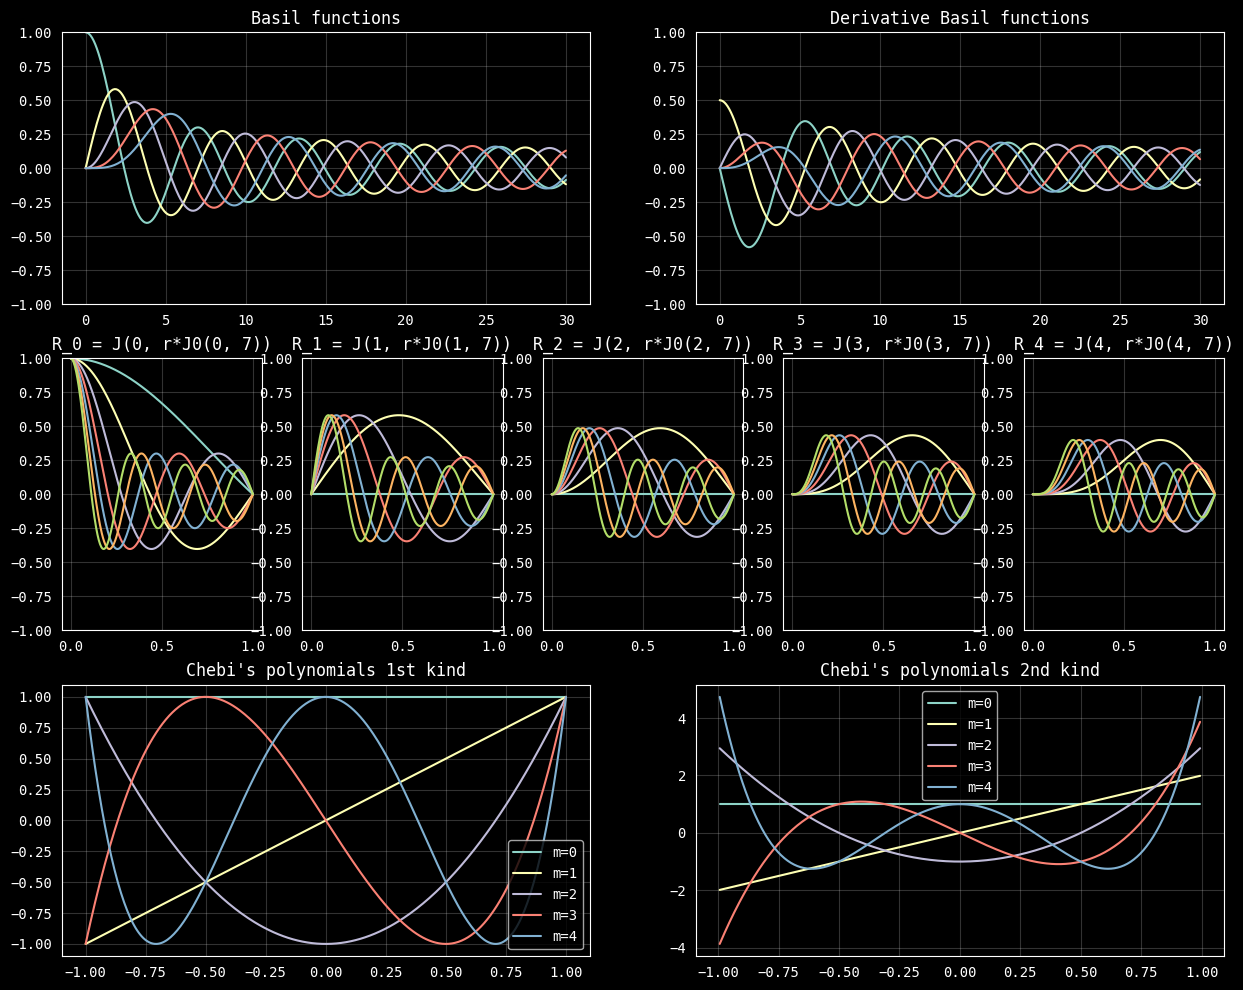

In [6]:
#bessel
def J(m:int,x:np.ndarray): # bessel function of the first kind
    return jv(m,x.reshape(-1))

def J0(m:int,n:int): # zeros of the m-th bessel function
    if m == 0: return jn_zeros(m,n)
    else: return np.concatenate([[0], jn_zeros(m,n-1)])
JZ = np.array([J0(m,L) for m in range(M)]) # J0ML is the zeros of the bessel function of the first kind

def JP(m:int,x:np.ndarray): # derivative of the bessel function of the first kind
    return jvp(m,x)

def Tm(m:int,x:np.ndarray): # tchebyshev polynomial of the first kind
    return np.cos(m*np.arccos(x))

def Tchebychev2(m:int,x:np.ndarray): # tchebyshev polynomial of second kind
    return np.sin((m+1)*np.arccos(x))/np.sqrt(1-x**2)
Um = Tchebychev2 # U is the tchebyshev polynomial of the second kind

def Rml(m, l, r): # radial function
    return J(m, r*JZ[m,l])
    # return J(m, r*J0(m, L)[l])


# def Bessel(m:int,x:np.ndarray,n=70): # accurate until x ~ n+m
#     s = x.shape
#     x = x.reshape(-1)
#     b = np.zeros_like(x)
#     for l in range(n):
#         b += (-1)**l * (x/2)**(2*l+m) / (fact(l)*fact(l+m))
#     return b.reshape(s)

#plot
tmpM = 5
r = np.linspace(0, 30, 300)
plt.figure(figsize=(15,12))
plt.subplot(321)
for m in range(tmpM):
    plt.plot(r, J(m,r), label=f'm={m}')
plt.ylim(-1,1)
plt.title('Basil functions')

# plot the first bessel functions
plt.subplot(322)
for m in range(5):
    plt.plot(r, JP(m,r), label=f'm={m}')
plt.ylim(-1,1)
plt.title('Derivative Basil functions')

r = np.linspace(0, 1, 300)
for m in range(tmpM):
    plt.subplot(3, tmpM, tmpM+1+m)
    for l in range(L):
        plt.plot(r, J(m, r*J0(m, L)[l]), label=f'l={l}')
    plt.title(f'm={m}')
    plt.ylim(-1,1)
    plt.title(f'R_{m} = J({m}, r*J0({m}, {L}))')

# plot Tchebyshev polynomials
plt.subplot(325)
r = np.linspace(-1, 1, 300)
for m in range(tmpM):
    plt.plot(r, Tm(m,r), label=f'm={m}')
plt.title('Chebi\'s polynomials 1st kind')
plt.legend()

# plot Tchebyshev polynomials
plt.subplot(326)
r = np.linspace(-1, 1, 300)
for m in range(tmpM):
    plt.plot(r, Um(m,r), label=f'm={m}')
plt.title('Chebi\'s polynomials 2nd kind')
plt.legend()


plt.show()

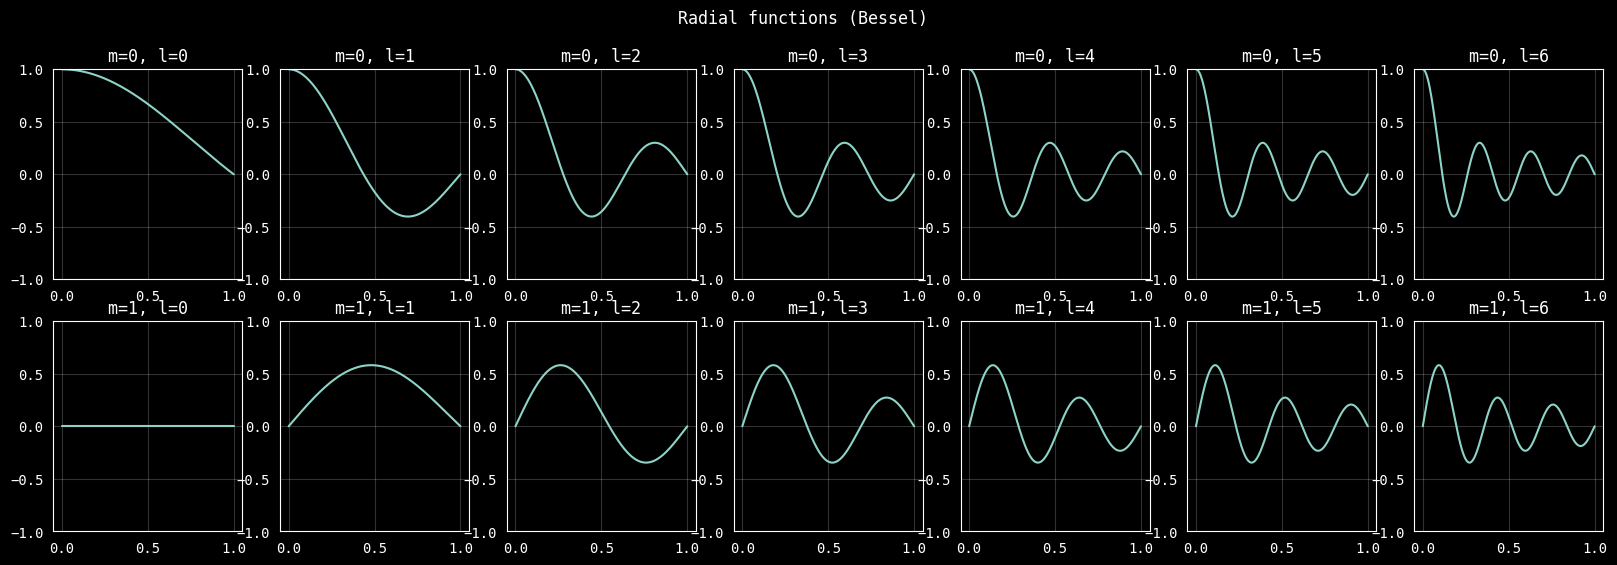

In [7]:
# bessel basis functions
plt.figure(figsize=(20,6))
r = np.linspace(0, 1, 300)
for m in range(M):
    for l in range(L):
        plt.subplot(M, L, m*L+l+1)
        plt.plot(r, Rml(m, l, r), label=f'm={m}, l={l}')
        plt.title(f'm={m}, l={l}')
        plt.ylim(-1,1)
plt.suptitle('Radial functions (Bessel)')
plt.show()


## Reconstructing the emiss $g(r,\theta)$ from the Bessel coefficients
$g^{c,s}_m(r) = \sum_{l=0}^{\infty} a^{c,s}_{ml} J_{m}(x_{ml}r)$ , with $x_{ml}$ the $l$-th root of the $m$-th Bessel function.

In complex form:
$g_m(r) = \sum_{l=0}^{\infty} a_{ml} J_{m}(x_{ml}r)$

$r, \theta$ are the spherical coordinates, $m$ is the harmonic, $c,s$ are the cosine and sine coefficients, $a$ are the Bessel coefficients, $J_m$ is the Bessel function of the first kind of order $m$.

Note on imaginary/aritmetic version of the Fourier series:
- $\sum_{m=-\infty}^{\infty} a_m e^{im\theta} = \sum_{m=-\infty}^{\infty} a^c_m \cos(m\theta) + i a^s_m \sin(m\theta)$
- $a^c_m = a_m + a_{-m} = 2 Re(a_m)$ 
- $a^s_m = i(a_m - a_{-m}) = 2 Im(a_m)$

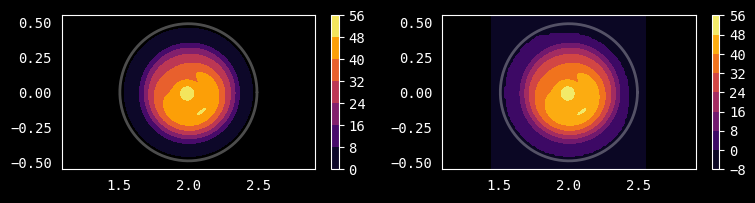

In [8]:
# def calc_g(r, θ, a): # r: vector of radii, θ: vector of angles, a vector of coefficients (complex numbers)
#     assert a.shape == (M,L) and a.dtype==complex, f'a.shape: {a.shape}, a.dtype: {a.dtype}'
#     g = np.zeros((len(r), len(θ)), dtype=complex)
#     for m in range(M):
#         # gm = np.dot(a[m], J(m, r*JZ[m,:][:,None]))
#         gm = np.dot(a[m], J(m, r*J0(m, L)[:,None]))
#         g += gm[:,None] * np.exp(1j*m*θ)
#     return np.abs(g).T 

def calc_g(r, θ, a): # equivalent (slower, but maybe clearer) implementation
    g = np.zeros((len(r), len(θ)), dtype=complex)
    for m in range(M):
        gm = sum([a[m,l] * Rml(m, l, r) for l in range(L)])
        g += gm[:,None] * np.exp(-1j*m*θ)
    return np.abs(g).T

r = np.linspace(0,1,FINESSE) # create a vector of radii
θ = np.linspace(0,2*π,FINESSE) # create a vector of angles

g = calc_g(r, θ, A)/MINR # calculate the g emissivity map

rr, θθ = np.meshgrid(r, θ) # create a meshgrid of r and θ
rθ = np.stack([rr, θθ], axis=-1)

xy = np.zeros_like(rθ) # convert to cartesian coordinates
xy[:,:,0] = rθ[:,:,0] * MINR * np.cos(rθ[:,:,1])
xy[:,:,1] = rθ[:,:,0] * MINR * np.sin(rθ[:,:,1]) 

#plot
plt.figure(figsize=(9,2))
cbar_min, cbar_max = np.min([np.min(g), np.min(EMISS)]), np.max([np.max(g), np.max(EMISS)])
xlm, xlM, ylm, ylM = np.min(XY_GT[:,:,0]), np.max(XY_GT[:,:,0]), np.min(XY_GT[:,:,1]), np.max(XY_GT[:,:,1])
plt.subplot(121)
plt.contourf(xy[:,:,0]+MAJR, xy[:,:,1], g)
plt.plot(FW[:,0], FW[:,1], 'w', lw=2, alpha=0.3)
plt.axis('equal')
plt.grid(False)
plt.xlim(xlm, xlM); plt.ylim(ylm, ylM)
plt.colorbar()

plt.subplot(122)
plt.contourf(XY_GT[:,:,0], XY_GT[:,:,1], EMISS)
plt.plot(FW[:,0], FW[:,1], 'w', lw=2, alpha=0.3)
plt.axis('equal')
plt.grid(False)
plt.xlim(xlm, xlM); plt.ylim(ylm, ylM)
plt.colorbar()
plt.show()

## Getting the Bessel coefficients

### Line of signt definition and visualization
<img src="data/geom.jpg" alt="Geometry Image" width="300"/>

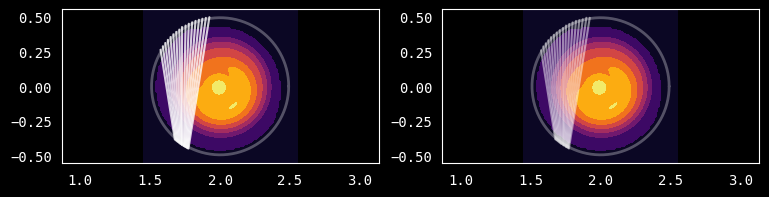

In [9]:
#functions to convert line of sight in format (pinhole, angle) to (Φ, p) 
def phα2line(ph, α): # convert line of sight in format (pinhole, angle) to standard line in the form ax + by + c = 0, returns a, b, c
    return np.array([-np.sin(α), np.cos(α), np.sin(α)*ph[0]-np.cos(α)*ph[1]])
    
def line2pΦ(line): # convert standard line in the form ax + by + c = 0 to (Φ, p), returns Φ, p
    a, b, c = line
    #calc point on the line closeesto to (RM, ZM)
    xp = (b*(b*RM - a*ZM) - a*c)/(a**2 + b**2)
    yp = (a*(-b*RM + a*ZM) - b*c)/(a**2 + b**2)
    return np.sqrt((xp-RM)**2 + (yp-ZM)**2), np.arctan2(yp-ZM, xp-RM)

def dist2line(p, line): # calculate the distance from a point to a line, returns distance line: [a, b, c] p: [x, y]
    (x,y), (a,b,c) = p, line
    return np.abs(a*x + b*y + c) / np.sqrt(a**2 + b**2)

def draw_line(line, color='w', alpha=0.5, lw=1.5): # line: [a,b,c], ax+by+c=0,
    # assume to already have a plot
    a,b,c = line
    if np.abs(a) < np.abs(b):
        x = np.linspace(R0, R1, 200)
        y = -(a*x + c)/b
    else:
        y = np.linspace(Z0, Z1, 200)
        x = -(b*y + c)/a
    outside = ((x-RM)**2 + (y-ZM)**2) < (R_FW+GSPAC/2)**2
    x, y = x[outside], y[outside]
    plt.plot(x, y, alpha=alpha, color=color, lw=lw)

def intersect(l1, l2): # calculate the intersection of two lines, returns intersection point
    (a1, b1, c1), (a2, b2, c2) = l1, l2
    den = b1*a2 - a1*b2
    # assert np.abs(den) > 1e-6, f'Parallel lines'#: {l1}, {l2}, den: {den:.3f}, b1*a2: {b1*a2:.3f}, a1*b2: {a1*b2:.3f}'
    if np.abs(den) < 1e-6: return np.array([np.nan, np.nan]) # parallel lines
    x = (c1*b2 - b1*c2)/den
    y = (a1*c2 - a2*c1)/den
    return np.array([x, y])



# test 
nrays, start_angle, span_angle, pinhole_position, idxs_to_keep = RFX_SXR_NRAYS[RFX_I], RFX_SXR_STARTS[RFX_I], RFX_SXR_SPANS[RFX_I], RFX_SXR_PINHOLES[RFX_I], RFX_SXR_TO_KEEP[RFX_I]
rays, _, _ = create_rfx_fan(nrays, start_angle, span_angle, pinhole_position, idxs_to_keep, ret_all=True)

# calc angles
αs = np.linspace(start_angle, start_angle+span_angle, nrays)[idxs_to_keep]

lines = np.zeros((len(rays),3))
for i in range(len(rays)):
    lines[i] = phα2line(pinhole_position, αs[i])  

ps, Φs = np.zeros((len(rays)), dtype=float), np.zeros((len(rays)), dtype=float)
for i in range(len(rays)):
    ps[i], Φs[i] = line2pΦ(lines[i])

# plot
plt.figure(figsize=(9,2))
plt.subplot(121)
plt.contourf(XY_GT[:,:,0], XY_GT[:,:,1], EMISS)
plt.plot(FW[:,0], FW[:,1], 'w', lw=2, alpha=0.3)
plt.axis('equal')
plt.xlim(R0, R1); plt.ylim(Z0, Z1)
plt.grid(False)
# plot rays
for r in rays: 
    plt.plot(r[:,0], r[:,1], 'w', alpha=0.8)

plt.subplot(122)
plt.contourf(XY_GT[:,:,0], XY_GT[:,:,1], EMISS)
plt.plot(FW[:,0], FW[:,1], 'w', lw=2, alpha=0.3)
plt.axis('equal')
# plt.xlim(R0, R1); plt.ylim(Z0, Z1)
plt.grid(False)
# plot lines
for l in lines: draw_line(l)

### LOS Conversion

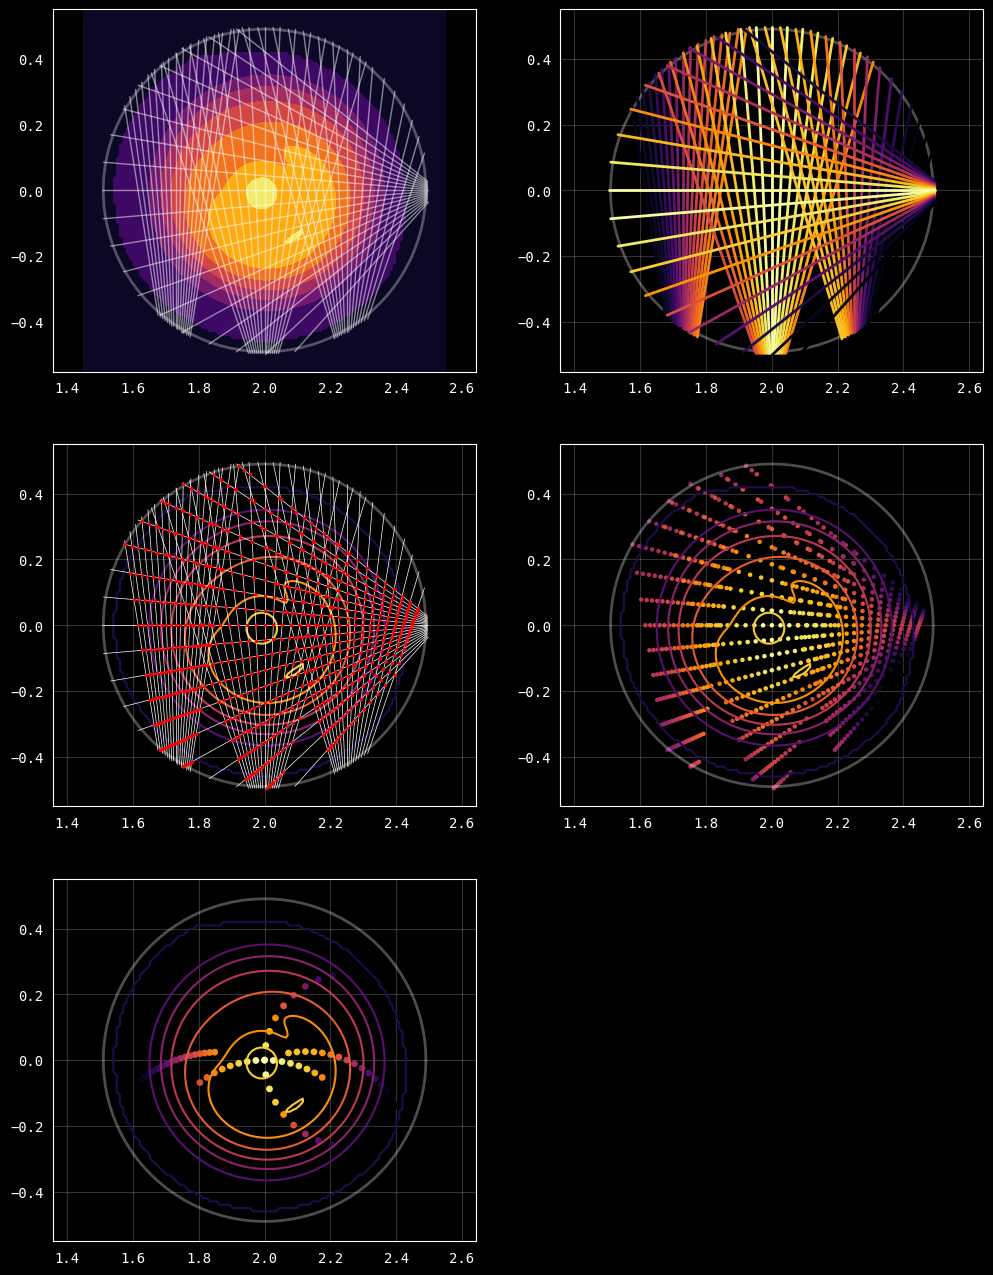

In [10]:
  # get rfx los
ps, Φs = np.zeros(len(SXR)), np.zeros(len(SXR))
lines = np.zeros((len(SXR),3))

idx = 0
for nr, startα, spanα, ph, keep_idxs in zip(RFX_SXR_NRAYS, RFX_SXR_STARTS, RFX_SXR_SPANS, RFX_SXR_PINHOLES, RFX_SXR_TO_KEEP):
    αs = np.linspace(startα, startα+spanα, nr)[keep_idxs]
    idx0 = idx
    for i in range(len(αs)):
        lines[idx] = phα2line(ph, αs[i])
        ps[idx], Φs[idx] = line2pΦ(lines[idx])
        idx += 1

# last = 9
# ps, Φs = ps[-last:], Φs[-last:]
# lines = lines[-last:]
# SXR = SXR[-last:]

# print(f'lines: \n{lines}')
# print(f'ps: {ps}')
# print(f'Φs: {Φs}')

# plot
plt.figure(figsize=(12,16))
plt.subplot(321)
plt.contourf(XY_GT[:,:,0], XY_GT[:,:,1], EMISS)
plt.plot(FW[:,0], FW[:,1], 'w', lw=2, alpha=0.3)
plt.axis('equal')
plt.xlim(R0, R1); plt.ylim(Z0, Z1)
plt.grid(False)
for l in lines: draw_line(l, lw=1, alpha=.5)    

# now plot the lines, but the color is decided by the SXR value
plt.subplot(322)
# plt.contourf(XY_GT[:,:,0], XY_GT[:,:,1], EMISS)
plt.plot(FW[:,0], FW[:,1], 'w', lw=2, alpha=0.3)
plt.axis('equal')
plt.xlim(R0, R1); plt.ylim(Z0, Z1)
# plt.grid(False)
# plot lines
for i, l in enumerate(lines): 
    draw_line(l, color=CMAP(SXR[i]/max(SXR)), lw=2, alpha=1)

# plot the intersection points
plt.subplot(323)
plt.contour(XY_GT[:,:,0], XY_GT[:,:,1], EMISS)
plt.plot(FW[:,0], FW[:,1], 'w', lw=2, alpha=0.3)
plt.axis('equal')
plt.xlim(R0, R1); plt.ylim(Z0, Z1)
# plt.grid(False)
for l in lines: draw_line(l, lw=0.5, alpha=1)   

intersections, values = [], []
for i in range(0, len(lines)-(HOR1_INTERVAL[1]-HOR1_INTERVAL[0])): # do not intersect vertical los with other vertical los
    for j in range(len(lines)-(HOR1_INTERVAL[1]-HOR1_INTERVAL[0]), len(lines)):
        assert i != j, f'Intersection of the same line: {i}, {j}'
        try: p = intersect(lines[i], lines[j])
        except AssertionError as e: print(e)
        if ((p[0]-RM)**2 + (p[1]-ZM)**2) < (R_FW+GSPAC/2)**2:
            intersections.append(p)
            values.append((SXR[i] + SXR[j])/2)

intersections = np.array(intersections)
plt.plot(intersections[:,0], intersections[:,1], 'ro', ms=1.5)

plt.subplot(324)
plt.contour(XY_GT[:,:,0], XY_GT[:,:,1], EMISS)
plt.plot(FW[:,0], FW[:,1], 'w', lw=2, alpha=0.3)
plt.axis('equal')
plt.xlim(R0, R1); plt.ylim(Z0, Z1)
# plt.grid(False)
plt.scatter(intersections[:,0], intersections[:,1], c=values, cmap=CMAP_NAME, s=5)

# scatter the (p, Φ) values
plt.subplot(325)
plt.contour(XY_GT[:,:,0], XY_GT[:,:,1], EMISS) 
plt.plot(FW[:,0], FW[:,1], 'w', lw=2, alpha=0.3)
plt.scatter(RM+ps*np.cos(Φs), ZM+ps*np.sin(Φs), c=SXR, cmap=CMAP_NAME, s=15)
plt.axis('equal')
plt.xlim(R0, R1); plt.ylim(Z0, Z1)
# plt.grid(False)

# plt.subplot(326)
# # simply plot the ps values (stem plot on the Φs)
# plt.stem(Φs, ps)
# plt.xlabel('Φ')
# plt.ylabel('p') 


plt.show()

### Bessel coefficients calculation
$f_{ml} (p) = a_{ml} \int_p^1 2  \frac{R_{ml}(r) cos(m * cos^{-1}(p/r)) r}{\sqrt{r^2 - p^2}} dr$

with $R_{ml}(r) = J_m(x_{ml}r)$

Converting in matrix form:

$\mathbf{f} = \mathbf{W} \cdot \mathbf{g} \\ \mathbf{g} = \mathbf{W}^{-1} \cdot \mathbf{f}$


Alternative (maybe this is more correct):

$f(p, \phi) = \sum_{m=0}^{\infty} f_m(p) e^{im\phi} $

In [11]:
# first rescale the ps by MINR
ps = ps/MINR

In [12]:
# functions to calculate f_ml
def λfmlp(m,l,p): return lambda r: 2 * Rml(m, l, r) * Tm(m, p/r) * r / np.sqrt(r**2 - p**2) 
def calc_fml(m,l,p): return quad(λfmlp(m,l,p), p, 1)[0] # calculate the fmlp coefficients

100%|██████████| 68/68 [00:01<00:00, 41.07it/s]


f_pΦs: 
[19.82  18.866 17.827 16.71  15.517 14.245 12.886 11.442  9.927  8.383
  6.865  5.444  4.181  3.12   2.279  1.644  1.181 21.116 22.91  23.985
 24.494 24.852 25.373 25.972 26.259 25.943 25.098 24.031 22.957 21.838
 20.512 18.871 16.896  0.034  0.292  0.951  2.16   3.951  6.206  8.701
 11.23  13.702 16.133 18.508 20.659 22.318 23.347 23.922 24.426  4.124
  7.611 11.143 14.571 18.039 20.848 22.755 24.715 26.259 26.176 25.41
 24.656 22.607 18.764 14.085  9.394  5.269  2.305  0.698]
SXR: 
[19.054 18.278 17.375 16.336 15.293 14.028 12.821 11.335 10.184  8.382
  6.948  5.543  4.282  3.216  2.313  1.655  1.145 19.137 21.183 22.575
 23.449 24.1   24.781 25.569 25.913 25.473 24.489 23.286 21.989 20.573
 18.979 17.095 14.924 -0.05   0.26   0.966  2.207  3.986  6.22   8.724
 11.259 13.935 15.943 18.173 20.119 21.373 21.996 22.121 22.106  2.63
  5.309  8.518 12.05  15.877 19.252 21.793 24.189 25.958 25.608 24.319
 22.736 19.849 15.492 10.786  6.57   3.333  1.348  0.394]


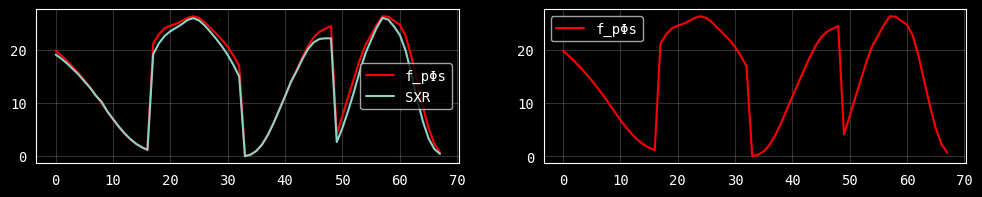

In [13]:
# recalculate the sxrs
f_pΦs = np.zeros((len(SXR)))
for i in tqdm(range(len(SXR))):
    for m in range(M):
        fm = sum([A[m,l] * calc_fml(m,l,ps[i]) for l in range(L)])
        f_pΦs[i] += fm * np.exp(-1j*m*Φs[i])
     
print(f'f_pΦs: \n{f_pΦs}')
print(f'SXR: \n{SXR}')

# plot
plt.figure(figsize=(12,2))
plt.subplot(121)
plt.plot(f_pΦs, 'r', label='f_pΦs')
plt.plot(SXR, label='SXR')
plt.legend()
plt.grid(True)
plt.subplot(122)
plt.plot(f_pΦs, 'r', label='f_pΦs')
plt.legend()
plt.grid(True)
plt.show()

## Inverse problem

WC: (68, 14), WT: (68, 28)
GC: 
[[20.83+0.03j  3.29+0.09j -3.96+0.02j  3.36-0.25j  0.85-0.31j  1.12-0.28j
   1.69+0.19j]
 [ 0.  -0.j    0.76-0.73j  0.36-0.49j -0.77-0.11j -0.93-0.42j -0.93+0.13j
   0.94+0.06j]]
GT: 
[[20.79-0.j    3.28+0.j   -3.93+0.j    3.61-0.j    0.94+0.j    1.09+0.j
   1.57+0.j  ]
 [ 0.  +0.j    1.07-2.85j  0.68-1.36j -0.78+0.23j -1.21-0.55j -1.23+0.41j
   0.61-0.1j ]]


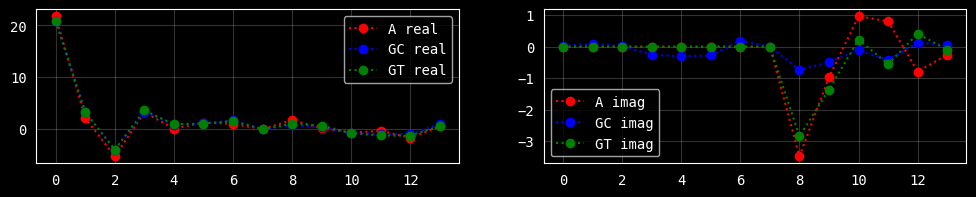

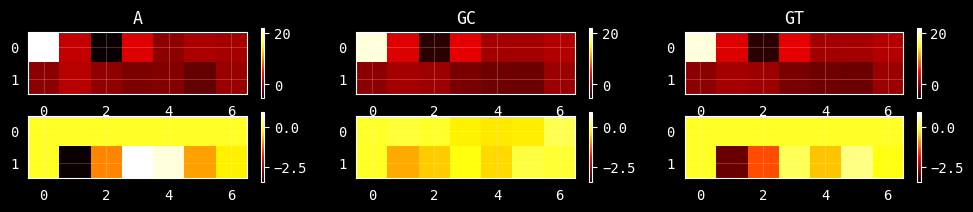

In [14]:
# f -> SXR (68), g -> a_ml coefficients (14 complex numbers), W -> (68, 14) matrix
# f = Wg -> g = W^-1 f -> but use pseudo-inverse/least squares problem

# print(f'ps: {ps}\nΦs: {Φs*180/π}')

#complex number version
WC = np.zeros((len(SXR), M, L), dtype=complex)
for i in range(len(SXR)):
    for m in range(M):
        for l in range(L):
            fml = calc_fml(m,l,ps[i])
            WC[i,m,l] = fml * np.exp(-1j*m*Φs[i])
WC = WC.reshape(len(SXR), M*L)
GC = lstsq(WC, SXR, rcond=SVD_TRSH)[0].reshape(M,L)

# trigonometric version
Wc, Ws = np.zeros((len(SXR), M, L), dtype=float), np.zeros((len(SXR), M, L), dtype=float)
for i in range(len(SXR)):
    for m in range(M):
        for l in range(L):
            fml = calc_fml(m,l,ps[i])
            Wc[i,m,l] = fml * np.cos(m*Φs[i])
            Ws[i,m,l] = fml * np.sin(m*Φs[i])
WT = np.concatenate([Wc, Ws], axis=1).reshape(len(SXR), 2*M*L)
print(f'WC: {WC.shape}, WT: {WT.shape}')
GT = lstsq(WT, SXR, rcond=SVD_TRSH)[0].reshape(2,M,L)
GT = GT[0] + GT[1]*1j

# G = GC
G = GT

np.set_printoptions(precision=2, suppress=True)

print(f'GC: \n{GC}')
print(f'GT: \n{GT}')

# plot
plt.figure(figsize=(12,2))
plt.subplot(121)
plt.plot(A.real.reshape(-1), 'ro:', label='A real')
plt.plot(GC.real.reshape(-1), 'bo:', label='GC real')
plt.plot(GT.real.reshape(-1), 'go:', label='GT real')
plt.legend()
plt.grid(True)

plt.subplot(122)
plt.plot(A.imag.reshape(-1), 'ro:', label='A imag')
plt.plot(GC.imag.reshape(-1), 'bo:', label='GC imag')
plt.plot(GT.imag.reshape(-1), 'go:', label='GT imag')
plt.legend()
plt.grid(True)

plt.show()

plt.figure(figsize=(12,2))
# plot 2 heatmaps side by side
plt.subplot(231)
maxare, minare = np.max([np.max(A.real), np.max(G.real)]), np.min([np.min(A.real), np.min(G.real)])
plt.imshow(A.real, cmap='hot', vmin=minare, vmax=maxare)
plt.colorbar()
plt.title('A')

plt.subplot(232)
plt.imshow(G.real, cmap='hot', vmin=minare, vmax=maxare)
plt.colorbar()
plt.title('GC')

plt.subplot(233)
plt.imshow(GT.real, cmap='hot', vmin=minare, vmax=maxare)
plt.colorbar()
plt.title('GT')


plt.subplot(234)
maxaim, minaim = np.max([np.max(A.imag), np.max(G.imag)]), np.min([np.min(A.imag), np.min(G.imag)])
plt.imshow(A.imag, cmap='hot', vmin=minaim, vmax=maxaim)
plt.colorbar()

plt.subplot(235)
plt.imshow(GC.imag, cmap='hot', vmin=minaim, vmax=maxaim)
plt.colorbar()

plt.subplot(236)
plt.imshow(GT.imag, cmap='hot', vmin=minaim, vmax=maxaim)
plt.colorbar()


plt.show()



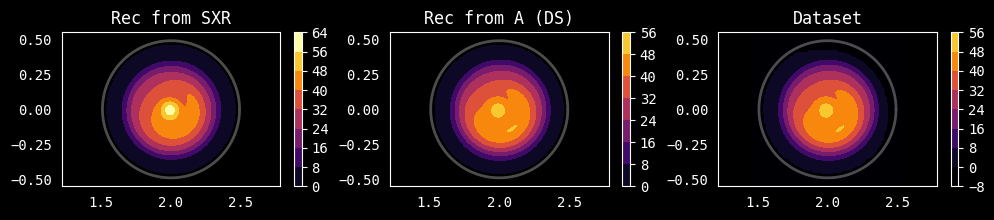

In [15]:
# calculate the g emissivity map using the new coefficients
r = np.linspace(0,1,FINESSE) # create a vector of radii
θ = np.linspace(0,2*π,FINESSE) # create a vector of angles

gg = calc_g(r, θ, G)/MINR # calculate the g emissivity map
ga = calc_g(r, θ, A)/MINR # calculate the g emissivity map

rr, θθ = np.meshgrid(r, θ) # create a meshgrid of r and θ
rθ = np.stack([rr, θθ], axis=-1)
xy = np.zeros_like(rθ) # convert to cartesian coordinates
xy[:,:,0] = rθ[:,:,0]*MINR * np.cos(rθ[:,:,1])
xy[:,:,1] = rθ[:,:,0]*MINR * np.sin(rθ[:,:,1]) 

#plot
plt.figure(figsize=(12,2))
maxe, mine = np.max([np.max(gg), np.max(ga)]), np.min([np.min(gg), np.min(ga)])

plt.subplot(131)
plt.contourf(xy[:,:,0]+MAJR, xy[:,:,1], gg, vmin=mine, vmax=maxe)
plt.plot(FW[:,0], FW[:,1], 'w', lw=2, alpha=0.3)
plt.axis('equal')
plt.grid(False)
plt.xlim(xlm, xlM); plt.ylim(ylm, ylM)
plt.colorbar()
plt.title('Rec from SXR')

plt.subplot(132)
plt.contourf(xy[:,:,0]+MAJR, xy[:,:,1], ga, vmin=mine, vmax=maxe)
plt.plot(FW[:,0], FW[:,1], 'w', lw=2, alpha=0.3)
plt.axis('equal')
plt.grid(False)
plt.xlim(xlm, xlM); plt.ylim(ylm, ylM)
plt.colorbar()
plt.title('Rec from A (DS)')

plt.subplot(133)
plt.contourf(XY_GT[:,:,0], XY_GT[:,:,1], EMISS, vmin=mine, vmax=maxe)
plt.plot(FW[:,0], FW[:,1], 'w', lw=2, alpha=0.3)
plt.axis('equal')
plt.grid(False)
plt.xlim(xlm, xlM); plt.ylim(ylm, ylM)
plt.colorbar()
plt.title('Dataset')

plt.show()

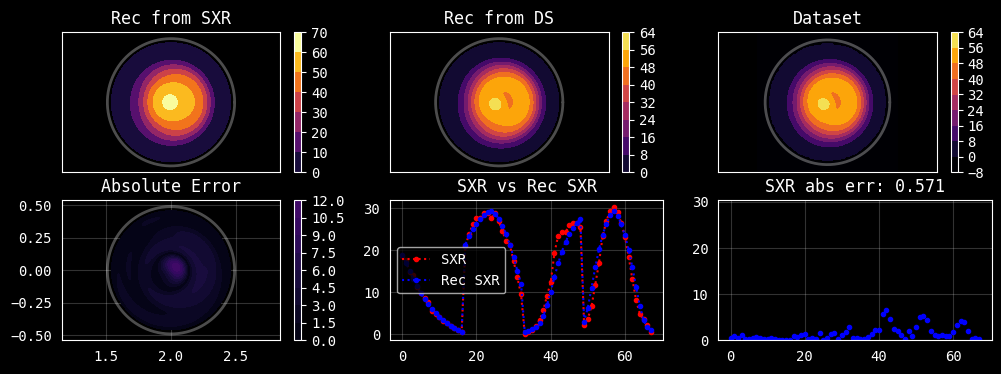

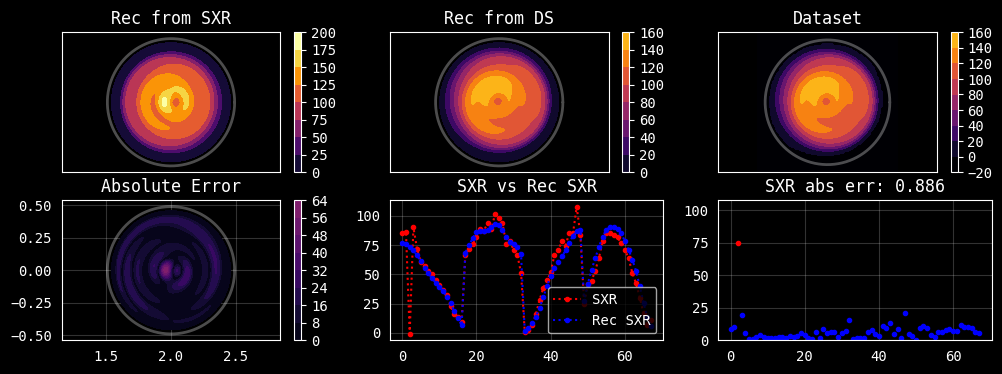

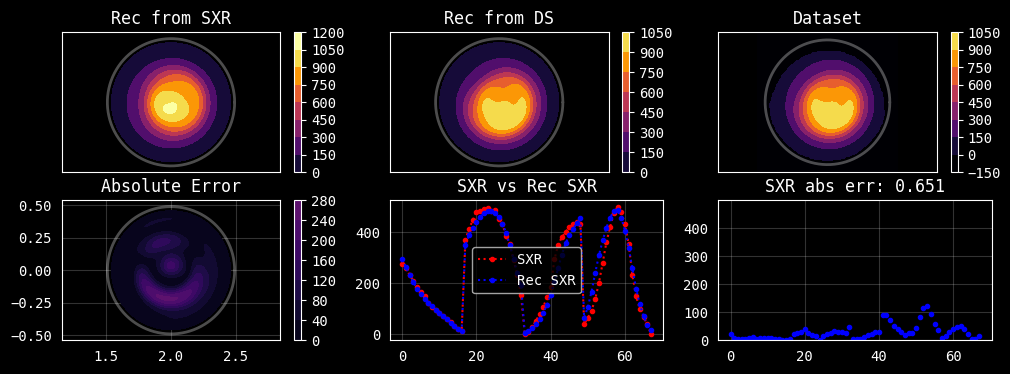

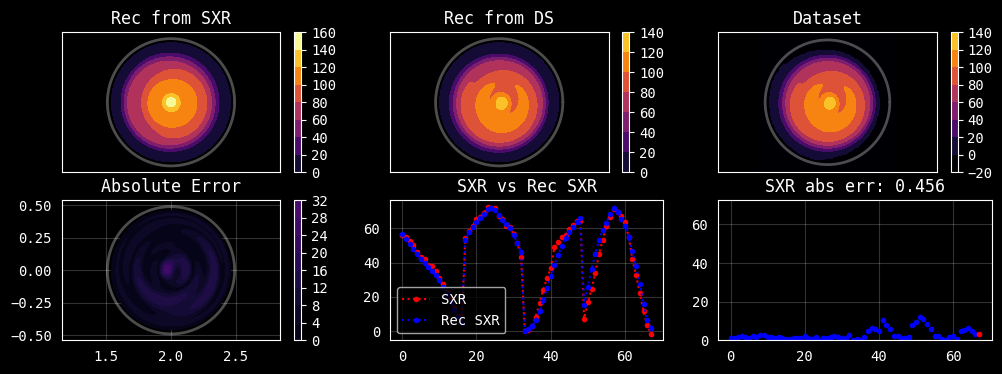

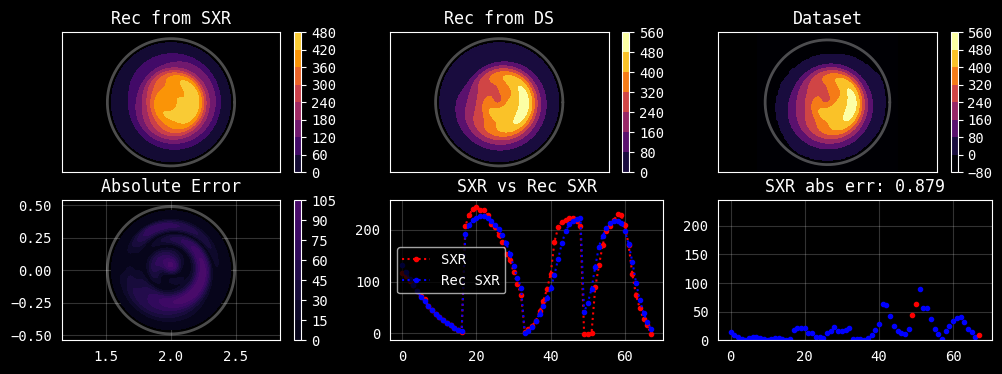

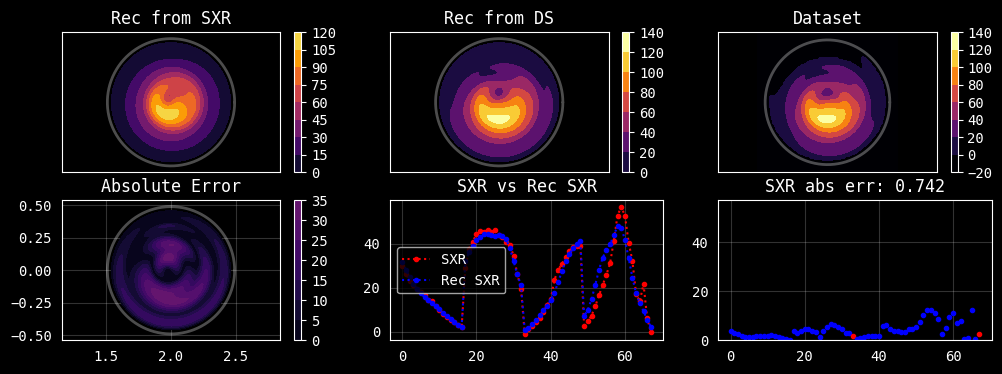

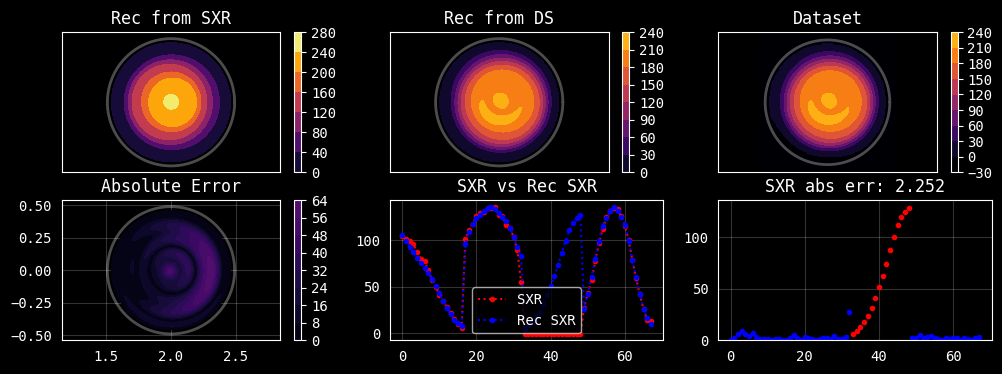

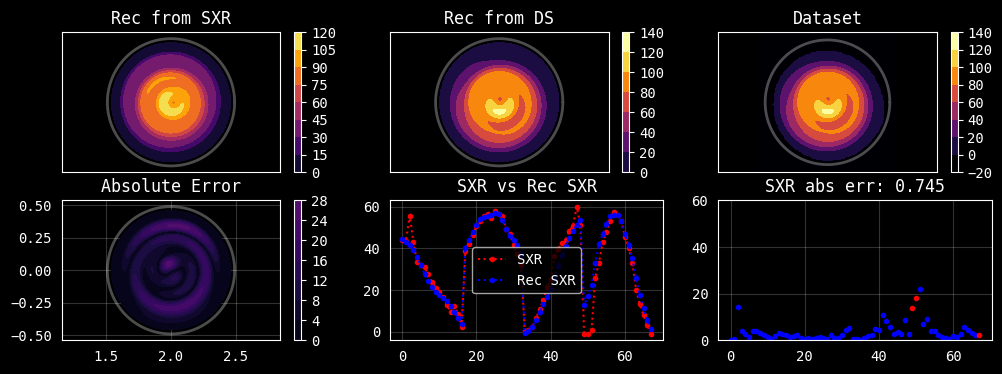

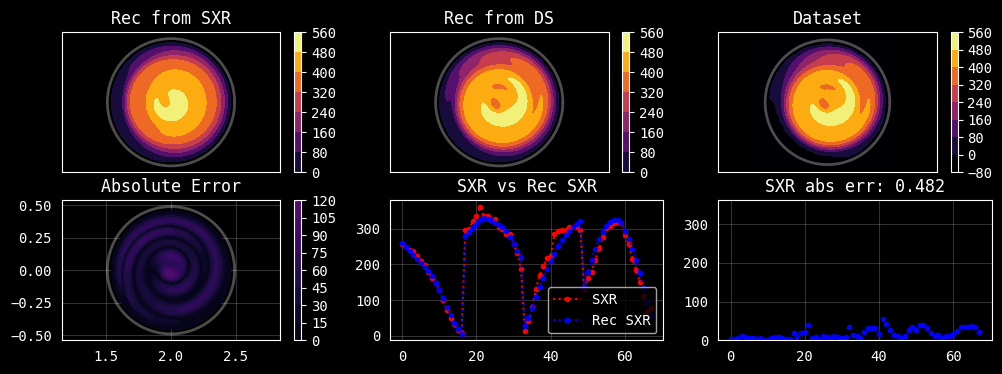

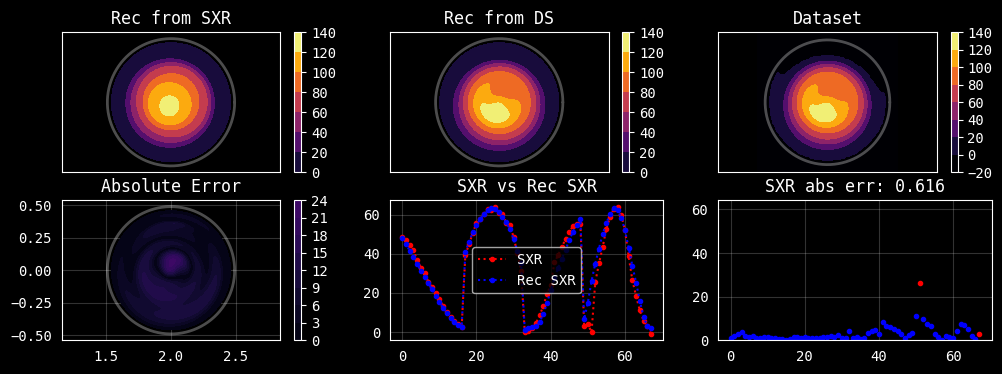

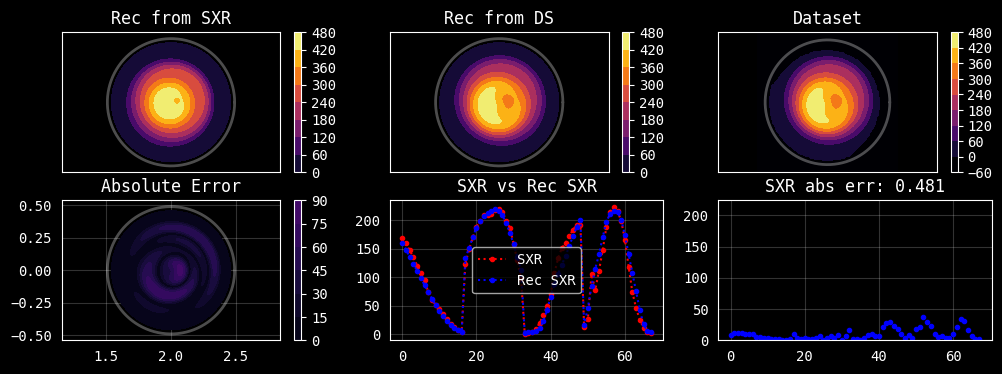

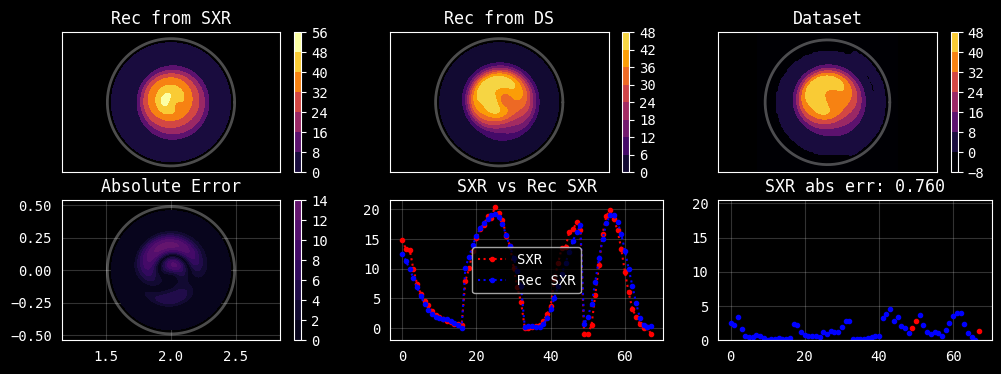

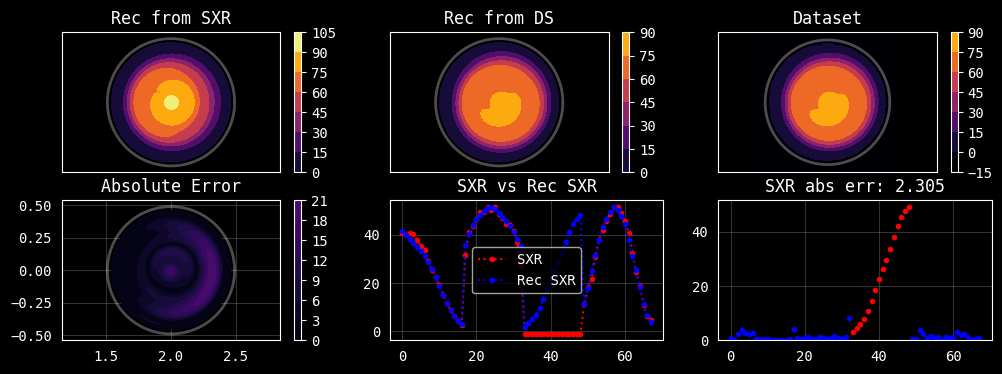

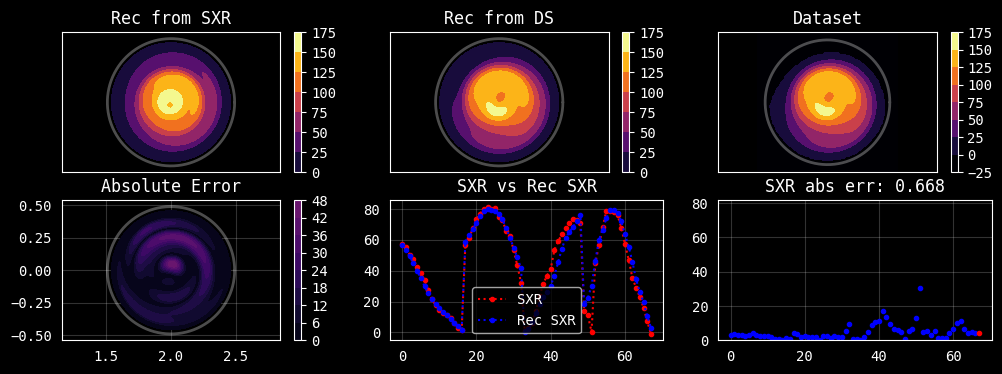

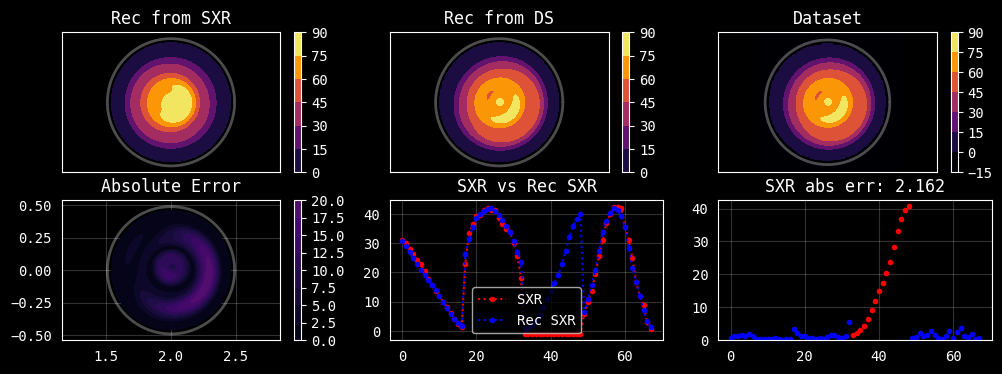

In [16]:
# test inversion on full dataset
ds = np.load('data/data_clean.npy')

def calc_inversion(sxr, rs, θs, masking=True, trig=False):
    if masking: mask = sxr < 0
    else: mask = np.zeros_like(sxr, dtype=bool)

    if trig: 
        gt = lstsq(WT[~mask], sxr[~mask], rcond=SVD_TRSH)[0].reshape(2,M,L) # g = W^-1 f, trigonometric version
        gc = gt[0] + gt[1]*1j # g = W^-1 f, complex 
        rc_sxr = WT @ gt.reshape(-1) # reconstruct the sxr
    else: 
        gc = lstsq(WC[~mask], sxr[~mask], rcond=SVD_TRSH)[0].reshape(M,L) # g = W^-1 f, complex version
        rc_sxr = WC @ gc.reshape(-1) # reconstruct the sxr

    gg = calc_g(rs, θs, gc)/MINR
    return gg, rc_sxr

# test
r, θ = np.linspace(0,1,FINESSE), np.linspace(0,2*π,FINESSE)
rand_idxs = np.random.randint(0, len(ds), 15)
for i in rand_idxs:
    sxr, em, bess_c = ds['data'][i][RFX_COMBINED_INTERVALS], ds['emiss'][i], ds['target'][i]
    a0c, a0s, a1c, a1s = bess_c[0:L], np.zeros(L), bess_c[L:2*L], bess_c[2*L:3*L]
    a0, a1 = a0c + a0s*1j, a1c + a1s*1j
    Bc = np.array([a0, a1], dtype=complex)
    
    gds = calc_g(r, θ, Bc)/MINR
    gg, rc_sxr = calc_inversion(sxr, r, θ)

    mine, maxe = np.min([np.min(gg), np.min(em)]), np.max([np.max(gg), np.max(em)])
    plt.figure(figsize=(12,4))
    plt.subplot(231)
    plt.contourf(xy[:,:,0]+MAJR, xy[:,:,1], gg, vmin=mine, vmax=maxe)
    plt.plot(FW[:,0], FW[:,1], 'w', lw=2, alpha=0.3)
    plt.axis('equal'), plt.xticks([]), plt.yticks([])
    plt.colorbar()
    plt.title('Rec from SXR')
    plt.subplot(232)
    plt.contourf(xy[:,:,0]+MAJR, xy[:,:,1], gds, vmin=mine, vmax=maxe)
    plt.plot(FW[:,0], FW[:,1], 'w', lw=2, alpha=0.3)
    plt.axis('equal'), plt.xticks([]), plt.yticks([])
    plt.colorbar()
    plt.title('Rec from DS')
    plt.subplot(233)
    plt.contourf(XY_GT[:,:,0], XY_GT[:,:,1], em, vmin=mine, vmax=maxe)
    plt.plot(FW[:,0], FW[:,1], 'w', lw=2, alpha=0.3)
    plt.colorbar()
    plt.axis('equal'), plt.xticks([]), plt.yticks([])
    plt.title('Dataset')
    plt.subplot(234)
    plt.contourf(xy[:,:,0]+MAJR, xy[:,:,1], np.abs(gg-gds), vmin=mine, vmax=maxe)
    plt.plot(FW[:,0], FW[:,1], 'w', lw=2, alpha=0.3)
    plt.colorbar()
    plt.axis('equal')
    plt.title('Absolute Error')
    plt.subplot(235)
    #plt ssxr vs reconstructed sxr
    MS = 3
    plt.plot(sxr, 'ro:', label='SXR', ms=MS)
    plt.plot(rc_sxr, 'bo:', label='Rec SXR', ms=MS)
    plt.legend()
    plt.grid(True)
    plt.title('SXR vs Rec SXR')
    plt.subplot(236)
    #plot error between sxr and reconstructed sxr
    mask = sxr < 0
    # create a vector of colors based on mask, red if masked, blue if not
    colors = np.array([(1,0,0) if m else (0,0,1) for m in mask])
    err = np.abs(sxr-rc_sxr)
    for i in range(len(sxr)):
        plt.plot(i, err[i], f'o{'r' if mask[i] else 'b'}:', ms=MS)
    #plot vertical lines where the sxr is masked
    plt.ylim(0, np.max(sxr))
    plt.title(f'SXR abs err: {np.linalg.norm(sxr-rc_sxr)/np.max(sxr):.3f}')
    plt.show()

